In [1]:
import pandas as pd
import numpy as np
from dmyplant2 import cred, MyPlant, Engine, msgFSM, FSM, bokeh_show, get_cycle_data2, get_cycle_data, v, chart
from pprint import pprint as pp


import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default='simple_white'
pio.renderers.default = "notebook"
    
cred()
mp = MyPlant(0)
Engine._list_cached_validations();

In [2]:
pio.templates;

In [3]:
fleet = mp.search_installed_fleet_by_contains_name("Forsa Hartmoor")
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
motor = fleet.iloc[3]
modes = ['???','OFF','MANUAL','AUTO']
success = [True,False]
#success = [True]
fleet.T
motor['IB Site Name'] + ' ' + motor['Engine ID'], modes, success

('Forsa Hartmoor M04', ['???', 'OFF', 'MANUAL', 'AUTO'], [True, False])

In [4]:
e=Engine.from_fleet(mp,motor)
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to='2022-01-15', successtime=300)
fsm.run1(enforce=True, silent=False) # run Finite State Machine

FSM: 100%|███████████████████████████| 551/551 [00:00<00:00, 8101.00 messages/s]


In [5]:
rda = fsm.starts
rda['stime'] = rda.apply(lambda x: x['starttime'].strftime('%d.%m.%Y %H:%M:%S'), axis=1)
rda['etime'] = rda.apply(lambda x: x['endtime'].strftime('%d.%m.%Y %H:%M:%S'), axis=1)
rda[['no','success','mode','stime','etime','startpreparation','starter','speedup','idle','synchronize','loadramp','cumstarttime','targetoperation','rampdown','coolrun','runout']].round(2)

no  success  mode                stime                etime  \
0   0     True   ???  11.01.2022 09:54:21  11.01.2022 14:57:18   
1   1     True   ???  11.01.2022 15:33:10  11.01.2022 15:50:37   
2   2    False  AUTO  11.01.2022 18:37:19  11.01.2022 18:44:41   
3   3    False  AUTO  11.01.2022 18:56:43  11.01.2022 19:08:22   
4   4    False  AUTO  12.01.2022 11:22:41  12.01.2022 11:24:53   
5   5     True  AUTO  13.01.2022 02:51:02  13.01.2022 04:03:09   
6   6     True  AUTO  13.01.2022 04:11:15  13.01.2022 08:49:43   
7   7     True  AUTO  14.01.2022 09:58:05  14.01.2022 10:33:09   
8   8     True  AUTO  14.01.2022 16:28:05  14.01.2022 19:33:11   

   startpreparation  starter  speedup  idle  synchronize  loadramp  \
0             97.95     4.24    24.00  6.35        13.02    126.89   
1             92.73     3.84    20.03  5.56        28.36    126.82   
2            442.40      NaN      NaN   NaN          NaN       NaN   
3             76.68     3.84    21.80  5.54        24.14    126.83   
4            106.12     4.14    21.08   NaN          NaN       NaN   
5             96.41     4.03    23.10  6.25         9.58    126.44   
6             60.61     3.63    18.89  5.15        28.75    126.51   
7             96.53     3.94    24.82  6.16         8.79    126.60   
8             99.23     3.93    22.48  6.07         9.49    126.51   

   cumstarttime  targetoperation  rampdown  coolrun  runout  
0        272.46         17718.31    127.73     9.99   48.58  
1        277.35           584.11    127.33     9.99   48.82  
2        442.40              NaN       NaN      NaN     NaN  
3        258.82           254.80    127.14     9.99   48.65  
4        131.34              NaN       NaN      NaN     NaN  
5        265.83          3875.23    127.46    10.01   48.66  
6        243.53         16279.04    127.52     9.99   48.25  
7        266.84          1651.12    127.31     9.90   48.35  
8        267.71         10652.03    127.53    10.00   48.94

In [65]:
from dowork import plot_now
vset = ['Various_Values_SpeedAct','Power_PowerAct','Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [{'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red', 'unit':'kW'},
        {'col':['power_diff'],'ylim': [-200, 200], 'color':'black', 'unit':'kW/s'},
        {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue','unit':'rpm'},
        {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange', 'unit':'mbar'},
        {'col':['Hyd_TempOil'],'ylim': [-100, 100], 'color':'violet', 'unit':'°C'},
        {'col':['Hyd_PressOilDif'],'ylim': [0, 10], 'color':'midnightblue', 'unit':'bar'},
        {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'dodgerblue', 'unit':'bar'},
        ]
startversuch = rda.iloc[8];
data = get_cycle_data(fsm, startversuch, max_length=None, min_length=None, cycletime=1, silent=True, p_data=vset)
data['power_diff'] = pd.Series(np.gradient(data['Power_PowerAct']))
fig = plot_now(fsm, data, startversuch,vset, dset, dfigsize=(12,3))
bokeh_show(fig)

von: 14.01.2022 16:28:05 bis: 14.01.2022 19:33:11


In [66]:

pwidth = 1500
pheight = 800 
ax_width = 90
asp = ax_width / pwidth
ddset = dset

if 'color' in ddset[0]:
    pdata = [ go.Scattergl(x=data['datetime'], y=data[ddset[0]['col'][0]], line_color=ddset[0]['color'] ,name=ddset[0]['col'][0], yaxis=f"y") ]
else:
    pdata = [ go.Scattergl(x=data['datetime'], y=data[ddset[0]['col'][0]] ,name=ddset[0]['col'][0], yaxis=f"y") ]
playout = {
    'showlegend':True,
    'legend': {
        'yanchor':"top",
        'y':0.99,
        'xanchor':"left",
        'x':0.025,
        'bgcolor': 'rgba(255,255,255,0.4)',
    },
    'title_text': f"{fsm._e} -- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}",
    'width':pwidth,
    'height':pheight,
    'xaxis':{ 'domain':[0.02,1-(len(ddset)-2)*asp]},
    'yaxis':{
        'title':f"{ddset[0]['col'][0]} [{ddset[0]['unit']}]",
        'anchor':"x",'overlaying':"y",'side':"left",'position':0.0
    }
}
if 'ylim' in ddset[0]:
        playout['yaxis'].update({'range': ddset[0]['ylim']})
if 'color' in ddset[0]:
        playout['yaxis'].update({'color': ddset[0]['color']})

if len(ddset) > 1:
    for i,graph in enumerate(ddset[1:]):
        yaxisname = f"yaxis{i+2}"
        playout[yaxisname] = {
            'title':f"{graph['col'][0]} [{graph['unit']}]",
            'anchor':"free",'overlaying':"y",'side':"right",'position':(1-asp*i),
        }
        if 'ylim' in graph:
            playout[yaxisname].update({'range':graph['ylim']})
        if 'color' in graph:
            playout[yaxisname].update({'color':graph['color']})
            pdata.append( go.Scattergl(x=data['datetime'], y=data[graph['col'][0]], line_color=graph['color'], name=graph['col'][0], yaxis=f"y{i+2}"))
        else:
            pdata.append( go.Scattergl(x=data['datetime'], y=data[graph['col'][0]], name=graph['col'][0], yaxis=f"y{i+2}"))

fig2 = go.Figure(data=pdata, layout=playout)
fig2.show()

In [30]:
import plotly.graph_objects as go
import plotly.io as pio

pdata = [
    go.Scattergl(x=data['datetime'],y=data['Power_PowerAct'], name='Power_PowerAct'), #Power_PowerAct
    go.Scattergl(x=data['datetime'],y=data['Various_Values_SpeedAct'],name="Various_Values_SpeedAct",yaxis="y2"),
    go.Scattergl(x=data['datetime'],y=data['Hyd_PressOil'],name="Hyd_PressOil",yaxis="y3"),
    go.Scattergl(x=data['datetime'],y=data['Hyd_TempOil'],name="Hyd_TempOil",yaxis="y4")
]


playout = {
    'title_text': f"{fsm._e} -- Start {startversuch['no']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}",
    'width':1000,
    'height':600,
    'xaxis':{ 'domain':[0,0.70]},
    'yaxis':{
        'title':dset[0]['col'][0],
        #'titlefont':{'color':"#1f77b4"},'tickfont':{'color':"#1f77b4"},
        'color':"#1f77b4",
        'anchor':"x",'overlaying':"y",'side':"left",'position':0.0,
        'range':(0,5000),
        },
    'yaxis2':{
        'title':"Various_Values_SpeedAct",
        #'titlefont':{'color':"#ff7f0e"},'tickfont':{'color':"#ff7f0e"},
        'color':"#ff7f0e",
        'anchor':"free",'overlaying':"y",'side':"right",'position':0.7,
        'range':(0,2000),
        },
    'yaxis3':{
        'title':"Hyd_PressOil",
        #'titlefont':{'color':"#d62728"},'tickfont':{'color':"#d62728"},
        'color':"#d62728",
        'anchor':"free",'overlaying':"y",'side':"right",'position':0.8,
        'range':(0,10),
        },
    'yaxis4':{
        'title':"Hyd_TempOil",
        #'titlefont':{'color':"#9467bd"},'tickfont':{'color':"#9467bd"},
        'color':"#9467bd",
        'anchor':"free",'overlaying':"y",'side':"right",'position':0.9,
        'range':(0,100),
        },
}

fig3 = go.Figure(data=pdata, layout=playout)
fig3.show()


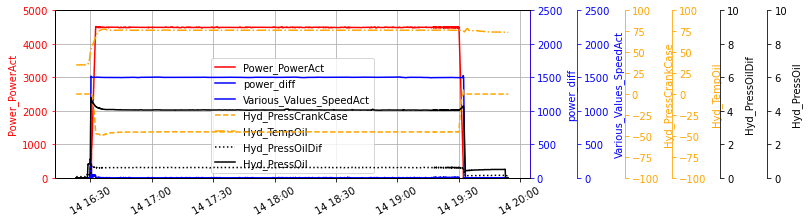

In [7]:
chart(data,dset, figsize=(12,3));

In [ ]:
dset

In [ ]:
svdetail=fsm.starts.iloc[6].to_dict()
#pp(svdetail)

In [ ]:
for i, v in enumerate(fsm.runlogdetail(startversuch, statechanges_only=True)):
    print(f"{i:3} {v}")

In [ ]:
print(fsm.results['runlogdetail'][0])
print(fsm.results['runlogdetail'][-1])

In [ ]:
print(len(fsm.results['runlogdetail']))

In [ ]:
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plfig1 = make_subplots(specs=[[{"secondary_y": True}]])
plfig1.add_trace(
    go.Scatter(x=[1,2,3], y=[40,50,60], name="yaxis data"),
    secondary_y = False,
)
plfig1.add_trace(
    go.Scatter(x=[2,3,4], y=[4,5,6], name="yaxis2 data"),
    secondary_y = True,
)
plfig1.show()
